# Importing dataset 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset
retail_data = pd.read_csv('OnlineRetail.csv')
retail_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01 December 2010,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,02 December 2010,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,03 December 2010,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,04 December 2010,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,05 December 2010,3.39,17850.0,United Kingdom


# Treating NULL values

In [2]:
# Checking shape of dataset
retail_data.shape

(541909, 8)

In [3]:
# checking null values
print("Initial null values in each column:\n", retail_data.isnull().sum())

Initial null values in each column:
 InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64


In [4]:
# treating null values 
mode_descriptions = retail_data.groupby('Country')['Description'].agg(lambda x: pd.Series.mode(x).iloc[0] if not x.mode().empty else None)

# Map the mode descriptions back to the main dataframe based on 'Country'
retail_data['Description'] = retail_data.apply(
    lambda row: mode_descriptions[row['Country']] if pd.isna(row['Description']) else row['Description'],
    axis=1
)

In [5]:
#checking null values again
retail_data.isnull().sum()

# i am not removing customerID as for my model its irrelevant

InvoiceNo           0
StockCode           0
Description         0
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [6]:
# Checking for negative entries in the 'Quantity' column and removing them
retail_data = retail_data[retail_data['Quantity'] > 0]

# Visualization of data

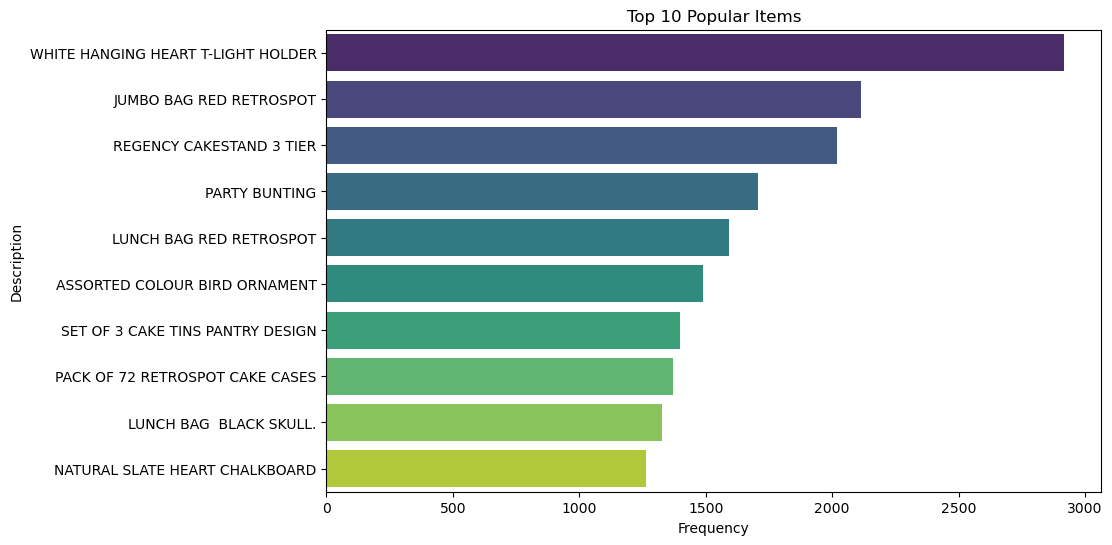

In [9]:
# Visualizing the top 10 items
top_items = retail_data['Description'].value_counts().head(10)
plt.figure(figsize=(10,6))
sns.barplot(x=top_items, y=top_items.index, palette='viridis')
plt.title('Top 10 Popular Items')
plt.xlabel('Frequency')
plt.show()

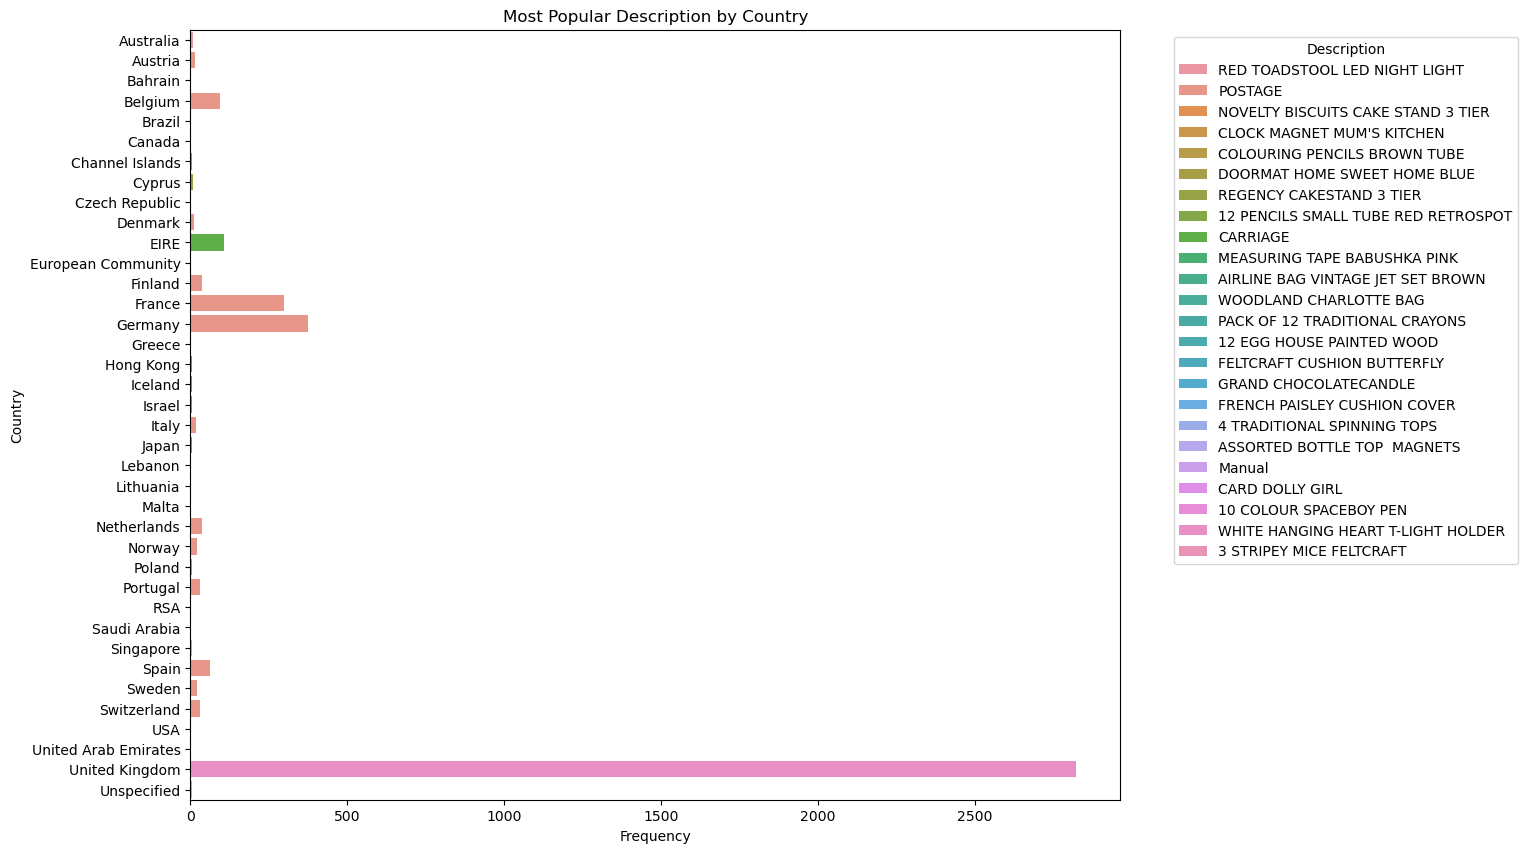

In [10]:
# Group by country and description, count the occurrences, and find the most popular in each country
country_popular = retail_data.groupby(['Country', 'Description']).size().reset_index(name='Counts')
country_top = country_popular.loc[country_popular.groupby('Country')['Counts'].idxmax()]

# Plotting
plt.figure(figsize=(12, 10))
sns.barplot(x=country_top['Counts'], y=country_top['Country'], hue=country_top['Description'], dodge=False)
plt.title('Most Popular Description by Country')
plt.xlabel('Frequency')
plt.ylabel('Country')
plt.legend(title='Description', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

C:\Users\Yagnam Joshi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Yagnam Joshi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


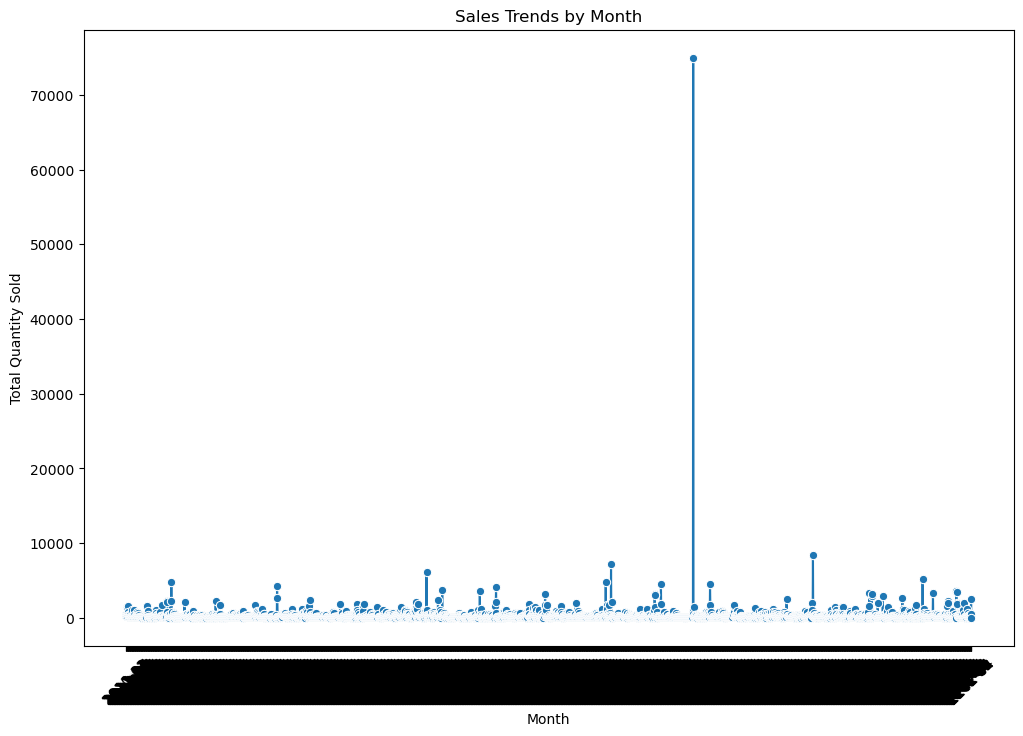

In [11]:
#month wise analysis 
retail_data['InvoiceDate'] = pd.to_datetime(retail_data['InvoiceDate'], errors='coerce', dayfirst=True)

# Remove any rows where the date couldn't be parsed (if any)
retail_data.dropna(subset=['InvoiceDate'], inplace=True)

# Proceed with extracting Year-Month
retail_data['Year_Month'] = retail_data['InvoiceDate'].dt.to_period('M')

# Aggregate data by 'Year_Month' for total quantity and invoice count
month_analysis = retail_data.groupby('Year_Month').agg(
    Total_Quantity=('Quantity', 'sum'),
    Invoice_Count=('InvoiceNo', 'nunique')
).sort_values(by='Year_Month', ascending=True)

# Plotting sales trends over months
plt.figure(figsize=(12, 8))
sns.lineplot(x=month_analysis.index.astype(str), y='Total_Quantity', data=month_analysis, marker='o')
plt.title('Sales Trends by Month')
plt.xlabel('Month')
plt.ylabel('Total Quantity Sold')
plt.xticks(rotation=45)
plt.show()

# Making models 

In [16]:
# Month based 
# Convert 'InvoiceDate' to datetime and extract just the month
retail_data['InvoiceDate'] = pd.to_datetime(retail_data['InvoiceDate'])
retail_data['Month'] = retail_data['InvoiceDate'].dt.month  # This extracts just the month number

# Group by month and description, then count occurrences
monthly_sales = retail_data.groupby(['Month', 'Description']).size().reset_index(name='Counts')
monthly_recommendation = monthly_sales.loc[monthly_sales.groupby('Month')['Counts'].idxmax()]

def recommend_monthly(month):
    # month should be an integer between 1 and 12
    recommendation = monthly_recommendation[monthly_recommendation['Month'] == month]
    return recommendation[['Description', 'Counts']]

# Example usage
print(recommend_monthly(5))  # For May


                             Description  Counts
9532  WHITE HANGING HEART T-LIGHT HOLDER      49


In [26]:
# Global moel
# Count occurrences of each description globally
global_sales = retail_data['Description'].value_counts().reset_index(name='Counts')
global_sales.columns = ['Description', 'Counts']
global_recommendation = global_sales.head(1)  # top 1 globally

def recommend_globally():
    return global_recommendation


In [33]:
# Group by country and description, then count occurrences
country_sales = retail_data.groupby(['Country', 'Description']).size().reset_index(name='Counts')
country_recommendation = country_sales.loc[country_sales.groupby('Country')['Counts'].idxmax()]

def recommend_country(country):
    recommendation = country_recommendation[country_recommendation['Country'] == country]
    return recommendation[['Description']]
recommend_country('United Kingdom')

,Description
7091,WHITE HANGING HEART T-LIGHT HOLDER


# Creating a function which will ask user to select the model

In [31]:
def prediction():
    print("Enter")
    print("1 to predict on basis of month")
    print("2 to predict on basis of country")
    print("3 to predict globally")
    choice=int(input("Choice: "))
    if(choice==1):
        m=int(input("Enter month (1-12): "))
        print(recommend_monthly(m))
    elif (choice==2):
        c=input("Enter country: ")
        print(recommend_country(c))
    elif(choice==3):
        print(recommend_globally())
    else:
        print("Wrong choice")

In [34]:
prediction()

Enter
1 to predict on basis of month
2 to predict on basis of country
3 to predict globally


Choice:  1
Enter month (1-12):  3


                             Description  Counts
5677  WHITE HANGING HEART T-LIGHT HOLDER      53
